In [0]:
import random
from collections import deque

import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tqdm.notebook import tqdm

In [0]:
GAMMA = 0.95
LEARNING_RATE = 0.001

MEMORY_SIZE = 1000000
BATCH_SIZE = 20

EXPLORATION_MAX = 1.0
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.995

In [0]:
class Game2048(object):
    def __init__(self, n, dims):
        assert n > 3, "n must be greater than 3"
        assert dims > 1, "dims must be greater than 1"
        self.n = n
        self.dims = dims
        self.n_news = ((n**self.dims)//2**4)*2
        self.shape = [n for i in range(self.dims)]
        self.actions = [(dim, 0) for dim in range(self.dims)] + [(dim, 1) for dim in range(self.dims)]
        self.reset()
    
    def reset(self):
        self.board = np.zeros(shape=self.shape)
        self.next_board = np.zeros(shape=self.shape)
        self.zero_mask = np.ones(shape=self.shape)
        self.score = 0
        self.last_move = False
        self.actions_taken = []
        self.add_numbers()
        return self.board
    
    def add_numbers(self):
        idx_gt_zero = np.argwhere(self.board)
        np.put(self.zero_mask,np.ravel_multi_index(idx_gt_zero.T, self.shape), 0, mode='raise')
        idx_zero = np.argwhere(self.zero_mask)
        np.put(self.zero_mask, np.ravel_multi_index(idx_gt_zero.T, self.shape), 1, mode='raise')
        if idx_zero.shape[0] > self.n_news:
            insert_idx = idx_zero[np.argsort(np.random.uniform(size=idx_zero.shape[0]))[:self.n_news], :]
        elif idx_zero.shape[0] > 0 and idx_zero.shape[0] <= self.n_news:
            insert_idx = idx_zero
        else:
            self.last_move = True
            return
        np.put(self.board, np.ravel_multi_index(insert_idx.T, self.shape), 2, mode='raise')
    
    def step(self, action_n):
        assert action_n < self.dims * 2, 'invalid action number'
        score = self.score
        if self.last_move:
            if len(self.actions_taken) == len(self.actions):
                return self.board, self.score, True
            else:
                if action_n not in self.actions_taken:
                    self.actions_taken.append(action_n)
        action = self.actions[action_n]
        self.next_board = np.copy(self.board)
        if action[1]:
            it_list = zip(range(self.n-1, 0, -1), range(self.n-2, -1, -1))
        else:
            it_list = zip(range(self.n-1), range(1,self.n))
        for i, next_i in it_list:
            index_base = np.ones(shape=[1 for x in range(self.dims)], dtype=np.int8)
            xi = np.take_along_axis(self.next_board, index_base*i, axis=action[0])
            xiplus = np.take_along_axis(self.next_board, index_base*next_i, axis=action[0])
            with np.nditer([xi, xiplus], flags=[], op_flags=[['readwrite'], ['readwrite']]) as it:
                for j, next_j in it:
                    if j[...] != 0 and next_j[...] == 0:
                        next_j[...] = j[...]
                        j[...] = 0
                    elif j[...] == next_j[...]:
                        next_j *= 2
                        j[...] = 0
                        score += next_j[...]
                        if self.last_move:
                            self.last_move = False
                            self.actions_taken = []
            np.put_along_axis(self.next_board, index_base*i, xi, axis=action[0])
            np.put_along_axis(self.next_board, index_base*next_i, xiplus, axis=action[0])
        self.board = self.next_board
        self.score = score
        self.add_numbers()
        return self.board, self.score, False
    

In [0]:
class DQNSolver:

    def __init__(self, observation_space, action_space):
        self.exploration_rate = EXPLORATION_MAX

        self.action_space = action_space
        self.memory = deque(maxlen=MEMORY_SIZE)

        self.model = Sequential()
        self.model.add(Dense(24, input_shape=(observation_space,), activation="relu"))
        self.model.add(Dense(24, activation="relu"))
        self.model.add(Dense(self.action_space, activation="linear"))
        self.model.compile(loss="mse", optimizer=Adam(lr=LEARNING_RATE))

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.action_space)
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def experience_replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        batch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, state_next, terminal in batch:
            q_update = reward
            if not terminal:
                q_update = (reward + GAMMA * np.amax(self.model.predict(state_next)[0]))
            q_values = self.model.predict(state)
            q_values[0][action] = q_update
            self.model.fit(state, q_values, verbose=0)
        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

In [0]:
def play_random(n, dims):
    game = Game2048(n=n, dims=dims)
    is_final = False
    while not is_final:
        action_n = int(np.random.uniform()*len(game.actions))
        new_board, score, is_final =  game.step(action_n=action_n)
    return game.board, score

In [14]:
board, score = play_random(n=4, dims=2);
print(board, score)

[[ 8. 16.  4.  8.]
 [ 2.  4.  2. 16.]
 [ 4. 64.  4.  2.]
 [ 8.  4.  2.  4.]] 488.0


In [15]:
board, score = play_random(n=4, dims=3);
print(board, score)

[[[ 2. 16.  2. 16.]
  [ 8.  4.  8.  2.]
  [32.  2.  4. 16.]
  [ 2. 64.  8.  2.]]

 [[ 4.  2. 64.  4.]
  [32. 16.  2. 32.]
  [ 2.  4. 32.  2.]
  [32.  2. 16. 32.]]

 [[32.  4. 16.  8.]
  [ 2. 32.  4.  2.]
  [16.  2.  8.  4.]
  [ 2. 32.  2.  8.]]

 [[ 2.  8.  2.  4.]
  [ 8.  2. 16. 32.]
  [ 2.  4. 64.  8.]
  [ 8. 16. 32.  2.]]] 3000.0


In [16]:
board, score = play_random(n=4, dims=2);
print(score)

544.0


In [17]:
board, score = play_random(n=4, dims=5);
print(score)

114340.0


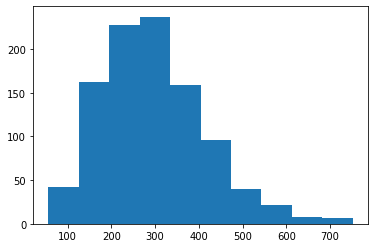

In [8]:
iterations = 1000
scores = np.zeros(shape=(iterations))
for i in range(iterations):
    _, scores[i] = play_random(4, 2)

import matplotlib.pyplot as plt
plt.hist(scores);

In [12]:
env = Game2048(n=4, dims=2)
observation_space = env.board.ravel().shape[0]
action_space = len(env.actions)
dqn_solver = DQNSolver(observation_space, action_space)
run = 0
for _ in tqdm(range(40)):
    run += 1
    state = env.reset()
    state = np.reshape(state, [1, observation_space])
    step = 0
    while True:
        step += 1
        action = dqn_solver.act(state)
        state_next, reward, terminal = env.step(action)
        reward = reward if not terminal else -reward
        state_next = np.reshape(state_next, [1, observation_space])
        dqn_solver.remember(state, action, reward, state_next, terminal)
        dqn_solver.experience_replay()
        state = state_next
        if terminal:
            print("Run: " + str(run) + ", exploration: " + str(dqn_solver.exploration_rate) + ", score: " + str(step))
            break

Run: 1, exploration: 0.9322301194154049, score: 33
Run: 2, exploration: 0.7666961448653229, score: 39
Run: 3, exploration: 0.6274028820538087, score: 40
Run: 4, exploration: 0.46444185833082485, score: 60
Run: 5, exploration: 0.33195389135223546, score: 67
Run: 6, exploration: 0.2532352299289372, score: 54
Run: 7, exploration: 0.17475600159032884, score: 74
Run: 8, exploration: 0.08662902049662846, score: 140
Run: 9, exploration: 0.048190768399801194, score: 117
Run: 10, exploration: 0.026673952849996664, score: 118
Run: 11, exploration: 0.014183896485845416, score: 126
Run: 12, exploration: 0.01, score: 124
Run: 13, exploration: 0.01, score: 220
Run: 14, exploration: 0.01, score: 60
Run: 15, exploration: 0.01, score: 173
Run: 16, exploration: 0.01, score: 208
Run: 17, exploration: 0.01, score: 78
Run: 18, exploration: 0.01, score: 215
Run: 19, exploration: 0.01, score: 260
Run: 20, exploration: 0.01, score: 90
Run: 21, exploration: 0.01, score: 472
Run: 22, exploration: 0.01, score: 3